<h1><font color="#113D68" size=6>Deep Learning con Python</font></h1>

<h1><font color="#113D68" size=5>Parte 5. Redes Neuronales Convolucionales</font></h1>

<h1><font color="#113D68" size=4>5. Análisis opiniones de películas</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo Cara</font><br>

</div>

---

<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [0. Contexto](#section0)
* [1. Conjunto de datos](#section1)
    * [1.1. Cargar el dataset IMDB](#section1.1)
* [2. Incrustar palabras](#section2)
* [3. Multilayer Perceptron](#section3)
    * [3.1. Librería y dataset](#section3.1)
    * [3.2. Extraer número de reseñas](#section3.2)
    * [3.3. Desarrollar MLP](#section3.3)
    * [3.4. Evaluación del modelo](#section3.4)
    * [2.5. Evaluación del modelo](#section3.5)
* [4. CNN Unidimensional](#section4)
    * [4.1. Librería y dataset](#section4.1)
    * [4.2. Desarrollar la CNN](#section4.2)
    * [4.3. Evaluación del modelo](#section4.3)

---
<a id="section0"></a>
# <font color="#004D7F" size=6> 0. Contexto</font>

En esta lección, descubriremos cómo puede predecir las opiniones de las críticas de películas como positivo o negativo:
* Dataset IMDB para el procesamiento del lenguaje natural.
* Usar la inserción de palabras para problemas de lenguaje natural.
* Desarrollar y evaluar un modelo de perceptrón multicapa clásico para NLP.
* Desarrollar una CNN unidimensional para NLP.

In [1]:
import tensorflow as tf
# Eliminar warning
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section1"></a>
# <font color="#004D7F" size=6>1. Conjunto de datos</font>

El conjunto de datos de IMDB contiene 50.000 reseñas de películas (buenas o malas) para entrenamiento y la misma cantidad para test. El problema es determinar si una crítica de película determinada tiene un sentimiento positivo o negativo.

Originalmente se logró un Accuracy del 88,89%.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre el dataset [IMBD](http://ai.stanford.edu/~amaas/data/sentiment/)


<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre el artículo original [_Learning Word Vectors for Sentiment Analysis_](http://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf)


<a id="section1.1"></a>
# <font color="#004D7F" size=5>1.1. Cargar el dataset IMDB</font>

La función `imdb.load data()` permite cargar y descargar (la primera vez) IMDB. Lo almacenará en su directorio personal en `~/.keras/datasets/imdb.pkl` como un archivo de 32 megabytes. 

Las oraciones de cada revisión se componen de una secuencia de números enteros.

De manera útil, la función `imdb.load data()` proporciona argumentos adicionales, como:
1. El número de palabras principales para cargar.
2. El número de palabras principales para omitir (como _"the's")_ 
3. La duración máxima de las revisiones. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre el dataset IMDB de [Keras](https://keras.io/api/datasets/)


In [3]:
# Load and Plot the IMDB dataset
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import imdb

# load the dataset
(X_train, y_train), (X_test, y_test)= imdb.load_data()

X= np.concatenate((X_train, X_test), axis=0)
y= np.concatenate((y_train, y_test), axis=0)


Vemos el tamaño

In [8]:
# summarize size
print(X.shape)
print(y.shape)


(50000,)
(50000,)


Imprimimos los valores de clase únicos.

In [9]:
# Summarize number of classes
print(np.unique(y))

[0 1]


Observamos el número total de palabras únicas en el conjunto de datos.

In [15]:
# Summarize number of words
print('Number of words: ')
print(len(np.unique(np.hstack(X))))

Number of words: 
88585


Finalmente, vemos la longitud media de las reseñas. 

Media de palabras: 234.76 (172.91)


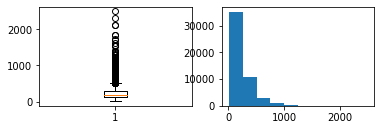

In [21]:
# Summarize review length
results= [len(x) for x in X]
print('Media de palabras: %.2f (%.2f)' % (np.mean(results),np.std(results)) )

# plot review length as a boxplot and histogram
plt.subplot(221)
plt.boxplot(results)
plt.subplot(222)
plt.hist(results)
plt.show()

---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section2"></a>
# <font color="#004D7F" size=6>2. Incrustar palabras</font>

Un avance reciente en el campo del NLP es la incrustación de palabras _(word embeddings)._ 
* Se trata de una técnica en la que las palabras se codifican como vectores de valor real en un espacio de alta dimensión, donde la similitud entre palabras en términos de significado se traduce en cercanía en el espacio vectorial. 
* Las palabras discretas se asignan a vectores de números continuos. 

Keras proporciona una forma conveniente de convertir representaciones enteras positivas de palabras en una incrustación de palabras mediante una capa `Embedding` que toma argumentos que:
* Definen el mapeo, incluido el número máximo de palabras esperadas, también llamado tamaño de vocabulario. 
* También le permite especificar la dimensionalidad de cada vector de palabra, denominada dimensión de salida.

Supongamos que solo nos interesan las primeras 5,000 palabras más utilizadas en el conjunto de datos. Por lo tanto:
* Nuestro tamaño de vocabulario será de 5,000. 
* Podemos optar por utilizar un vector de 32 dimensiones para representar cada palabra. 
* Finalmente, podemos optar por limitar la extensión máxima de la reseña a 500 palabras, truncando las reseñas más largas y rellenando las reseñas más cortas con valores 0. 

Para cargar el dataset:

```python
    imdb.load_data(num_words=5000)
```

Luego, Truncar o rellenar  una longitud de 500 usando la función `sequence.pad_sequences()`.

```python
    X_train = sequence.pad_sequences(X_train, maxlen=500)
    X_test = sequence.pad_sequences(X_test, maxlen=500)
```

Finalmente, la primera capa de nuestro modelo sería una capa de incrustación de palabras usando la clase `Embedding`:

```python
    Embedding(5000, 32, input_length=500)
```

La salida de esta primera capa sería una matriz con el tamaño de $32 × 500$. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i>
Puede obtener más información sobre la clase [Embedding](http://keras.io/layers/embeddings/)


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section3"></a>
# <font color="#004D7F" size=6>3. Multilayer Perceptron</font>

Podemos comenzar desarrollando un modelo MLP con una sola capa oculta. 

<a id="section3.1"></a>
# <font color="#004D7F" size=5>3.1. Librería y dataset</font>

Cargamos el conjunto de datos IMDB y lo simplificaremos con las 5.000 palabras principales. 

In [2]:
# MLP for the IMDB problem
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# load the dataset but only keep the top n words, zero the rest
vocab= 5000
(X_train, y_train), (X_test, y_test)= imdb.load_data(num_words= vocab)

X_train.shape

(25000,)

<a id="section3.2"></a>
# <font color="#004D7F" size=5>3.2. Extraer número de reseñas</font>

Limitamos las reseñas a 500 palabras.

In [3]:
max_words= 500
X_train= sequence.pad_sequences(X_train,maxlen=max_words)
X_test= sequence.pad_sequences(X_test,maxlen=max_words)


In [5]:
X_train.shape

(25000, 500)

<a id="section3.3"></a>
# <font color="#004D7F" size=5>3.3. Desarrollar MLP</font>

Ahora podemos crear nuestro modelo. Usaremos
1. Capa Embedding como entrada, estableciendo el vocabulario en 5,000, el tamaño del vector de la palabra en 32 dimensiones y la longitud de entrada en 500. 
2. La salida de esta primera capa será una matriz de tamaño $32 × 500$.
3. Capa Flatten para la salida de las capas Embedding a una dimensión.
4. Capa oculta densa de 250 neuronas con una función de activación ReLU. 
5. La capa de salida tiene 1 neurona con una activación sigmoidea para generar valores de 0 y 1. 
6. Funcioń de pérdida logarítmica y se optimiza mediante ADAM.

In [8]:
# create the model
model= Sequential()
model.add(Embedding(vocab,32, input_length= max_words))
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 250)               4000250   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 251       
Total params: 4,160,501
Trainable params: 4,160,501
Non-trainable params: 0
_________________________________________________________________


<a id="section3.4"></a>
# <font color="#004D7F" size=5>3.4. Evaluación del modelo</font>

Usaremos muy pocas épocas de entrenamiento, en este caso solo 2 y un tamaño de batch de 128. 

In [9]:
# Fit the model
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=2,batch_size=128,verbose=2)

# Final evaluation of the model
score= model.evaluate(X_test,y_test, verbose=0)
print('MLP Accuracy: %.2f' % (score[1]*100))


Epoch 1/2
196/196 - 24s - loss: 0.4651 - accuracy: 0.7577 - val_loss: 0.2893 - val_accuracy: 0.8769
Epoch 2/2
196/196 - 23s - loss: 0.1723 - accuracy: 0.9355 - val_loss: 0.3153 - val_accuracy: 0.8696
MLP Accuracy: 86.96


---
<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<a id="section4"></a>
# <font color="#004D7F" size=6>4. CNN Unidimensional </font>

Las mismas propiedades que hacen atractivo el modelo de CNN para aprender a reconocer objetos en imágenes pueden ayudar a aprender la estructura en párrafos de palabras, i.e., las técnicas de invarianza a la posición específica de las características.

<a id="section4.1"></a>
# <font color="#004D7F" size=5>4.1. Librería y dataset</font>

Keras admite convoluciones unidimensionales y agrupación mediante las clases `Conv1D` y `MaxPooling1D`, respectivamente.

In [4]:
# CNN for the IMDB problem
import numpy as np

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# load the dataset but only keep the top n words, zero the rest
vocab= 5000
(X_train, y_train), (X_test, y_test)= imdb.load_data(num_words= vocab)

# pad dataset to a maximum review length in words
max_words= 500
X_train= sequence.pad_sequences(X_train,maxlen=max_words)
X_test= sequence.pad_sequences(X_test,maxlen=max_words)


<a id="section4.2"></a>
# <font color="#004D7F" size=5>4.2. Desarrollar la CNN</font>

Ahora podemos definir nuestro modelo de red neuronal convolucional. Esta vez:

1. Después de la capa de entrada Embedding, insertamos una capa **Conv1D.** 
    * Esta capa convolucional tiene 32 mapas de características y lee representaciones de palabras embebidas 3 elementos vectoriales de la palabra embebida a la vez. 
2. Capa **MaxPooling1D** de 2x2. 
3. El resto de la red es igual que la red neuronal anterior.

In [6]:
# create the model
model= Sequential()
model.add(Embedding(vocab,32, input_length= max_words))
model.add(Conv1D(32,3,activation='relu', padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy']) 
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 250)               2000250   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 251       
Total params: 2,163,605
Trainable params: 2,163,605
Non-trainable params: 0
____________________________________________

<a id="section4.3"></a>
# <font color="#004D7F" size=5>4.3. Evaluación del modelo</font>

Veamos la evaluación del modelo

In [8]:
# Fit the model
model.fit(X_train,y_train, validation_data=(X_test,y_test),epochs=2,batch_size=128,verbose=2)

# Final evaluation of the model
score= model.evaluate(X_test,y_test, verbose=0)
print('CNN Accuracy: %.2f' % (score[1]*100))


Epoch 1/2
196/196 - 3s - loss: 0.1397 - accuracy: 0.9493 - val_loss: 0.3233 - val_accuracy: 0.8785
Epoch 2/2
196/196 - 3s - loss: 0.0803 - accuracy: 0.9751 - val_loss: 0.3674 - val_accuracy: 0.8744
CNN Accuracy: 87.44


<div style="text-align: right"> <font size=5> <a href="#indice"><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></a></font></div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#004D7F"></i> </font></div>